In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from mpl_toolkits.basemap import Basemap
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from yellowbrick.cluster import silhouette_visualizer
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("earthquakes_2023_global.csv")
df1 = df[df['type'] == "earthquake"]
df1

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2023-01-01T00:49:25.294Z,52.0999,178.5218,82.770,3.10,ml,14.0,139.0,0.8700,0.18,...,2023-03-11T22:51:52.040Z,"Rat Islands, Aleutian Islands, Alaska",earthquake,8.46,21.213,0.097,14.0,reviewed,us,us
1,2023-01-01T01:41:43.755Z,7.1397,126.7380,79.194,4.50,mb,32.0,104.0,1.1520,0.47,...,2023-03-11T22:51:45.040Z,"23 km ESE of Manay, Philippines",earthquake,5.51,7.445,0.083,43.0,reviewed,us,us
2,2023-01-01T03:29:31.070Z,19.1631,-66.5251,24.000,3.93,md,23.0,246.0,0.8479,0.22,...,2023-03-11T22:51:29.040Z,Puerto Rico region,earthquake,0.91,15.950,0.090,16.0,reviewed,pr,pr
3,2023-01-01T04:09:32.814Z,-4.7803,102.7675,63.787,4.30,mb,17.0,187.0,0.4570,0.51,...,2023-03-11T22:51:45.040Z,"99 km SSW of Pagar Alam, Indonesia",earthquake,10.25,6.579,0.238,5.0,reviewed,us,us
4,2023-01-01T04:29:13.793Z,53.3965,-166.9417,10.000,3.00,ml,19.0,190.0,0.4000,0.31,...,2023-03-11T22:51:38.040Z,"59 km SSW of Unalaska, Alaska",earthquake,1.41,1.999,0.085,18.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26637,2023-12-29T03:37:19.334Z,-6.9527,154.9829,10.000,5.20,mb,72.0,60.0,3.9240,0.93,...,2023-12-29T04:05:57.040Z,"89 km SW of Panguna, Papua New Guinea",earthquake,10.07,1.765,0.048,141.0,reviewed,us,us
26638,2023-12-29T04:38:54.109Z,32.3262,141.7386,10.000,5.10,mb,74.0,121.0,1.8030,0.70,...,2023-12-29T10:59:44.533Z,"Izu Islands, Japan region",earthquake,9.17,1.870,0.042,187.0,reviewed,us,us
26639,2023-12-29T08:42:05.747Z,-7.2411,68.0663,10.000,5.10,mb,60.0,54.0,12.7760,0.57,...,2023-12-29T08:57:05.040Z,Chagos Archipelago region,earthquake,8.02,1.792,0.090,40.0,reviewed,us,us
26640,2023-12-29T11:02:48.679Z,-19.1602,169.0428,153.264,4.70,mb,40.0,61.0,3.7460,0.82,...,2023-12-29T11:22:46.040Z,"49 km NNW of Isangel, Vanuatu",earthquake,8.52,7.433,0.081,46.0,reviewed,us,us


In [3]:
#get numerical columns
num_col = df1.select_dtypes(include='float64')
num_col

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
0,52.0999,178.5218,82.770,3.10,14.0,139.0,0.8700,0.18,8.46,21.213,0.097,14.0
1,7.1397,126.7380,79.194,4.50,32.0,104.0,1.1520,0.47,5.51,7.445,0.083,43.0
2,19.1631,-66.5251,24.000,3.93,23.0,246.0,0.8479,0.22,0.91,15.950,0.090,16.0
3,-4.7803,102.7675,63.787,4.30,17.0,187.0,0.4570,0.51,10.25,6.579,0.238,5.0
4,53.3965,-166.9417,10.000,3.00,19.0,190.0,0.4000,0.31,1.41,1.999,0.085,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...
26637,-6.9527,154.9829,10.000,5.20,72.0,60.0,3.9240,0.93,10.07,1.765,0.048,141.0
26638,32.3262,141.7386,10.000,5.10,74.0,121.0,1.8030,0.70,9.17,1.870,0.042,187.0
26639,-7.2411,68.0663,10.000,5.10,60.0,54.0,12.7760,0.57,8.02,1.792,0.090,40.0
26640,-19.1602,169.0428,153.264,4.70,40.0,61.0,3.7460,0.82,8.52,7.433,0.081,46.0


### Handle missing & null values - Multivariate Imputation

In [4]:
num_col.dropna()
num_col.isnull().sum()

latitude              0
longitude             0
depth                 0
mag                   0
nst                1387
gap                1388
dmin               1837
rms                   0
horizontalError    1521
depthError            0
magError           1643
magNst             1549
dtype: int64

In [5]:
from sklearn.experimental import enable_iterative_imputer #must be included to enable the usage of the imputer
from sklearn.impute import IterativeImputer

num_iterimpute = IterativeImputer(random_state=0)
clean_num_col = pd.DataFrame(num_iterimpute.fit_transform(num_col))
clean_num_col.columns = num_col.columns

display(num_col.isna().sum())
display(clean_num_col.isna().sum())

latitude              0
longitude             0
depth                 0
mag                   0
nst                1387
gap                1388
dmin               1837
rms                   0
horizontalError    1521
depthError            0
magError           1643
magNst             1549
dtype: int64

latitude           0
longitude          0
depth              0
mag                0
nst                0
gap                0
dmin               0
rms                0
horizontalError    0
depthError         0
magError           0
magNst             0
dtype: int64

### Data Normalization - MinMaxScaler

In [6]:
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Select the columns to exclude from normalization
columns_to_exclude = ['latitude', 'longitude']

# Select the columns to normalize
columns_to_normalize = [col for col in clean_num_col.columns if col not in columns_to_exclude]

# Fit the scaler on the selected columns
scaler = MinMaxScaler().fit(clean_num_col[columns_to_normalize])

# Transform the selected columns
newdf_norm = clean_num_col.copy()
newdf_norm[columns_to_normalize] = scaler.transform(clean_num_col[columns_to_normalize])

newdf_norm

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
0,52.0999,178.5218,0.125824,0.096154,0.059166,0.383041,0.263682,0.093407,0.091361,0.349646,0.021604,0.018551
1,7.1397,126.7380,0.120600,0.365385,0.100572,0.280702,0.267839,0.252747,0.061756,0.122713,0.018486,0.051266
2,19.1631,-66.5251,0.039979,0.255769,0.079869,0.695906,0.263356,0.115385,0.015591,0.262898,0.020045,0.020808
3,-4.7803,102.7675,0.098096,0.326923,0.066067,0.523392,0.257594,0.274725,0.109325,0.108439,0.053007,0.008399
4,53.3965,-166.9417,0.019529,0.076923,0.070667,0.532164,0.256754,0.164835,0.020609,0.032949,0.018931,0.023064
...,...,...,...,...,...,...,...,...,...,...,...,...
26423,-6.9527,154.9829,0.019529,0.500000,0.192585,0.152047,0.308701,0.505494,0.107519,0.029092,0.010690,0.161820
26424,32.3262,141.7386,0.019529,0.480769,0.197185,0.330409,0.277435,0.379121,0.098487,0.030822,0.009354,0.213713
26425,-7.2411,68.0663,0.019529,0.480769,0.164981,0.134503,0.439189,0.307692,0.086945,0.029537,0.020045,0.047882
26426,-19.1602,169.0428,0.228794,0.403846,0.118974,0.154971,0.306077,0.445055,0.091963,0.122515,0.018040,0.054651


### Elbow Method

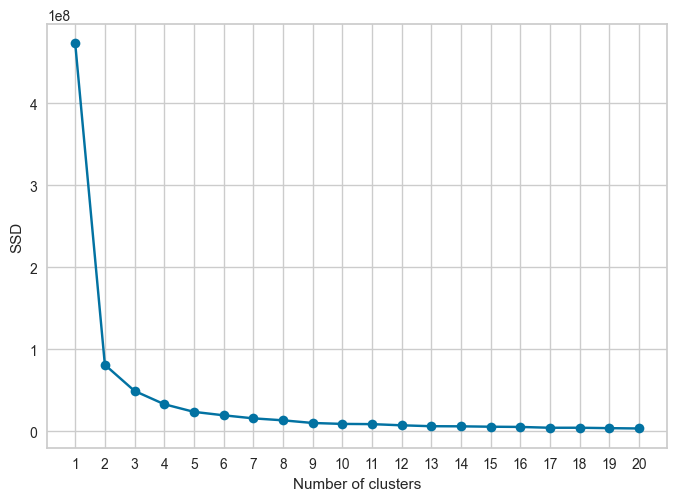

In [7]:
max_k = 20
ssd = []
for i in range(1, max_k+1):
    km_elbow = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km_elbow.fit(newdf_norm)
    ssd.append(km_elbow.inertia_) #Sum of squared distances of samples to their closest cluster center

# plot
plt.plot(range(1, max_k+1), ssd, marker='o')
plt.xticks(range(1, max_k+1))
plt.xlabel('Number of clusters')
plt.ylabel('SSD')
plt.show()

### K-Means

In [8]:
from sklearn.cluster import KMeans

# set number of cluster to get labels
km = KMeans(n_clusters = 2, random_state=1)
km.fit(newdf_norm)

KMeans(n_clusters=2, random_state=1)

In [9]:
# Merge cluster set
df_clustered = newdf_norm.copy()
df_clustered['label']=km.labels_
df_clustered

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst,label
0,52.0999,178.5218,0.125824,0.096154,0.059166,0.383041,0.263682,0.093407,0.091361,0.349646,0.021604,0.018551,0
1,7.1397,126.7380,0.120600,0.365385,0.100572,0.280702,0.267839,0.252747,0.061756,0.122713,0.018486,0.051266,0
2,19.1631,-66.5251,0.039979,0.255769,0.079869,0.695906,0.263356,0.115385,0.015591,0.262898,0.020045,0.020808,1
3,-4.7803,102.7675,0.098096,0.326923,0.066067,0.523392,0.257594,0.274725,0.109325,0.108439,0.053007,0.008399,0
4,53.3965,-166.9417,0.019529,0.076923,0.070667,0.532164,0.256754,0.164835,0.020609,0.032949,0.018931,0.023064,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26423,-6.9527,154.9829,0.019529,0.500000,0.192585,0.152047,0.308701,0.505494,0.107519,0.029092,0.010690,0.161820,0
26424,32.3262,141.7386,0.019529,0.480769,0.197185,0.330409,0.277435,0.379121,0.098487,0.030822,0.009354,0.213713,0
26425,-7.2411,68.0663,0.019529,0.480769,0.164981,0.134503,0.439189,0.307692,0.086945,0.029537,0.020045,0.047882,0
26426,-19.1602,169.0428,0.228794,0.403846,0.118974,0.154971,0.306077,0.445055,0.091963,0.122515,0.018040,0.054651,0


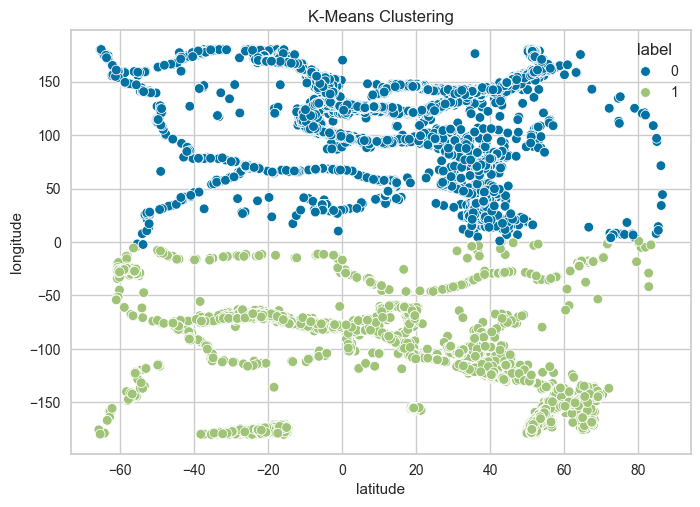

In [10]:
sns.scatterplot(x="latitude", y="longitude", hue="label", data=df_clustered)
plt.title('K-Means Clustering')
plt.show()

### Silhouette Score

In [11]:
from sklearn.metrics import silhouette_score

# Assuming you have a DataFrame called df_clustered with a column 'label'
# And assuming you have a numpy array X containing your features

# Compute silhouette score
silhouette_avg = silhouette_score(newdf_norm, df_clustered['label'])

print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.7136271938207533


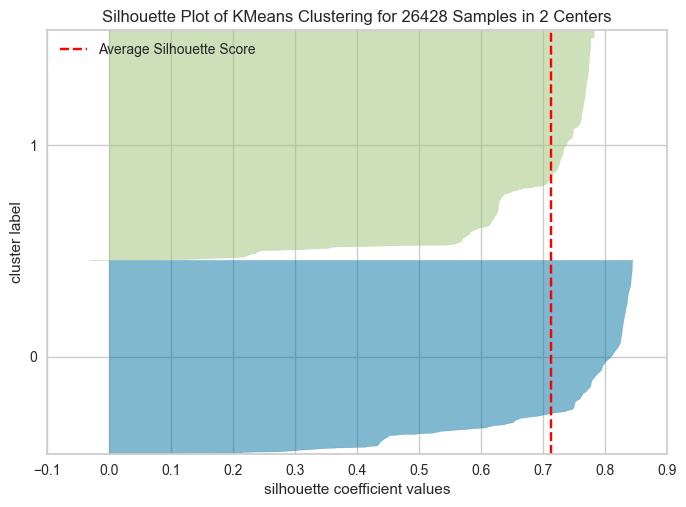

SilhouetteVisualizer(ax=<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 26428 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=2, random_state=1))

In [12]:
from yellowbrick.cluster import silhouette_visualizer
from sklearn.cluster import KMeans

# Visualize silhouette score
silhouette_visualizer(km, newdf_norm, colors='yellowbrick')

In [13]:
df_base = df_clustered[["latitude","longitude"]]
df_base['mag']= df["mag"]
df_base['label']=km.labels_
df_base

,latitude,longitude,mag,label
0,52.0999,178.5218,3.10,0
1,7.1397,126.7380,4.50,0
2,19.1631,-66.5251,3.93,1
3,-4.7803,102.7675,4.30,0
4,53.3965,-166.9417,3.00,1
...,...,...,...,...
26423,-6.9527,154.9829,4.60,0
26424,32.3262,141.7386,4.50,0
26425,-7.2411,68.0663,4.70,0
26426,-19.1602,169.0428,4.70,0


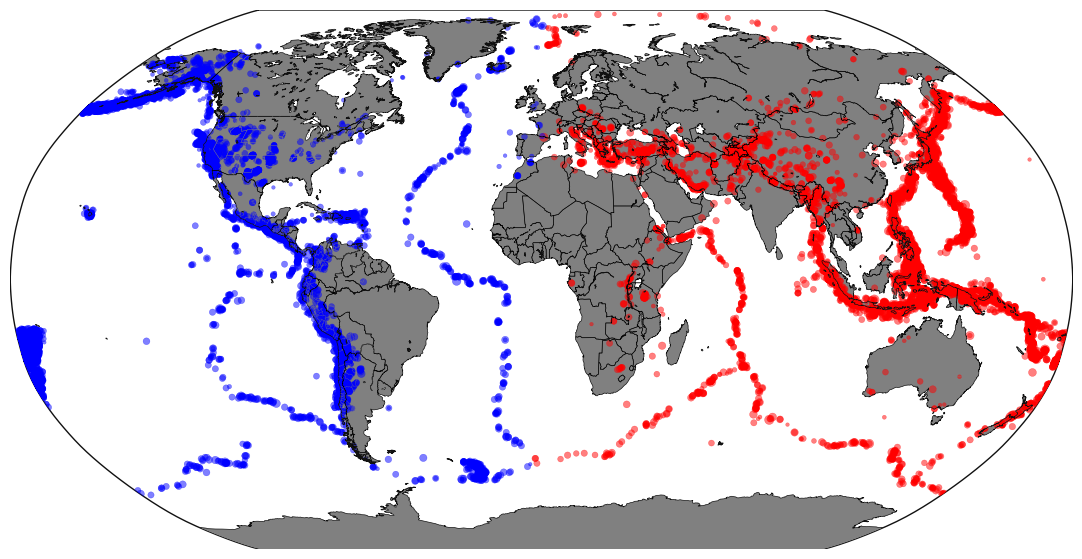

In [14]:
# Create a new map
fig = plt.figure(figsize=(14, 7))
map = Basemap(projection='robin', resolution='l', area_thresh=1000.0, lat_0=0, lon_0=0)

# Draw coastlines, country boundaries, and fill the continents
map.drawcoastlines(linewidth=0.5)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='gray')

# Convert latitude and longitude to map coordinates
x, y = map(df_base["longitude"].values, df_base["latitude"].values)

# Get cluster labels from your clustering result
cluster_labels = df_base['label']  # Replace with the actual cluster labels from your dataframe

# Define a colormap for differentiating clusters
cluster_colors = {0: 'red', 1: 'blue'}  # Customize the colors and labels based on your clustering results

# Plot the data points for each cluster with different colors
for label in set(cluster_labels):
    cluster_data = df_base[cluster_labels == label]
    x_cluster, y_cluster = map(cluster_data["longitude"].values, cluster_data["latitude"].values)
    map.scatter(x_cluster, y_cluster, s=cluster_data["mag"].values**2, c=cluster_colors[label], alpha=0.5)

# Draw country boundaries
map.drawcountries(linewidth=0.5, linestyle='solid', color='black')

# Draw state boundaries within countries
map.drawstates(linewidth=0.2, linestyle='solid', color='gray')

# Show the map
plt.show()

### Sampling - SMOTE

In [15]:
label_counts = df_clustered['label'].value_counts()

# Display the counts
print("Count of label 0:", label_counts.get(0, 0))
print("Count of label 1:", label_counts.get(1, 0))
# print("Count of label 2:", label_counts.get(2, 0))

Count of label 0: 12095
Count of label 1: 14333


label
1    14333
0    12095
Name: count, dtype: int64


Text(0.5, 1.0, 'Class Distribution')

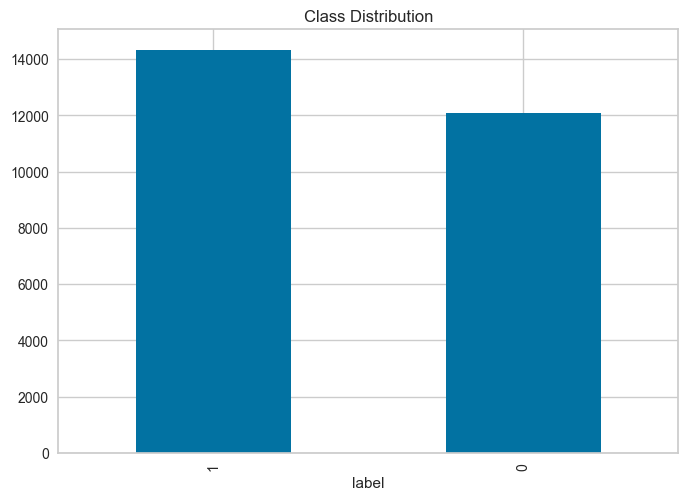

In [16]:
print(df_clustered["label"].value_counts())
df_clustered["label"].value_counts().plot(kind="bar")
plt.title("Class Distribution")

In [17]:
# SMOTE
import imblearn
smt = imblearn.over_sampling.SMOTE(sampling_strategy="minority", random_state=42, k_neighbors=5)

# Min Max Normalization on the features (without target)
X = df_clustered.drop(["label","latitude","longitude"], axis=1)
y = df_clustered["label"]
features = X.columns

In [18]:
# Fit smote
X_res, y_res = smt.fit_resample(X, y)

label
0    14333
1    14333
Name: count, dtype: int64


Text(0.5, 1.0, 'Class Distribution')

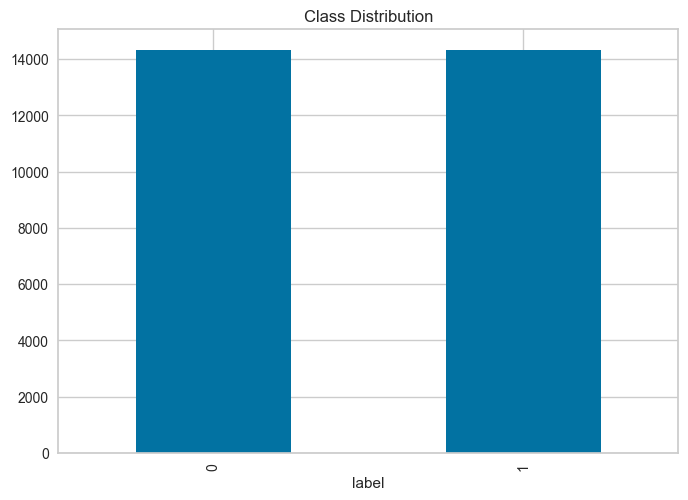

In [19]:
print(y_res.value_counts())
y_res.value_counts().plot(kind="bar")
plt.title("Class Distribution")

### Attribute Selection - SelectKBest Chi-Squared Test

In [20]:
from sklearn.feature_selection import SelectKBest, chi2

# Assuming X_res is your feature matrix and y_res is your target variable
select_feature = SelectKBest(chi2, k='all').fit(X_res, y_res)

# Get the selected features
selected_features = np.asarray(X_res.columns)[select_feature.get_support()]

# Display the selected features
print(selected_features)

['depth' 'mag' 'nst' 'gap' 'dmin' 'rms' 'horizontalError' 'depthError'
 'magError' 'magNst']


<AxesSubplot: xlabel='score', ylabel='Feature'>

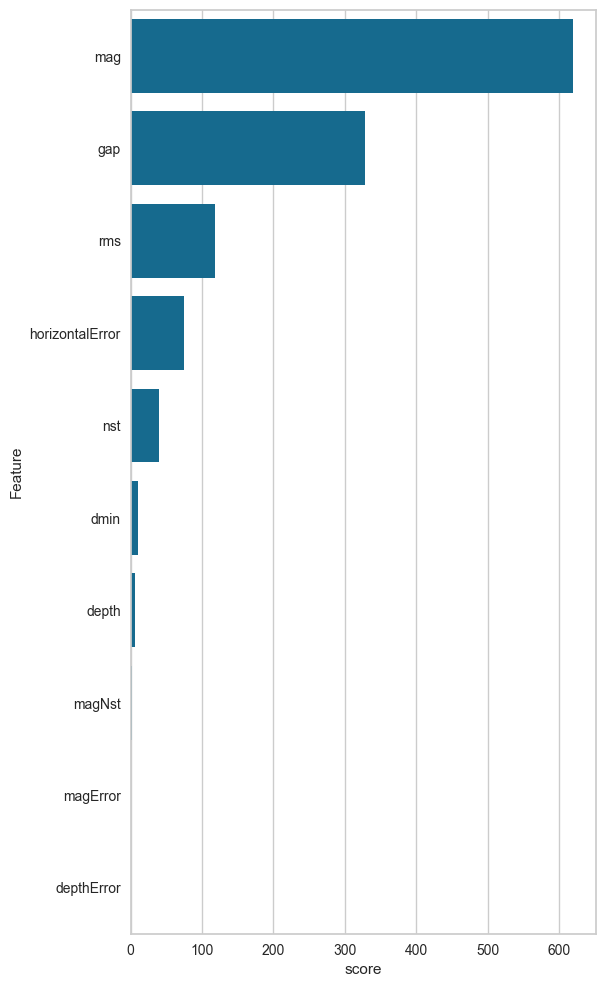

In [21]:
#Plot the scores used for the attribute selection
score = pd.DataFrame(select_feature.scores_ , X_res.columns).sort_values(0, ascending=False).reset_index().rename(columns={0:"score", "index":"Feature"})

f, ax = plt.subplots(figsize=(6, 12))

sns.barplot(data=score, x="score", y="Feature", color="b")

<AxesSubplot: >

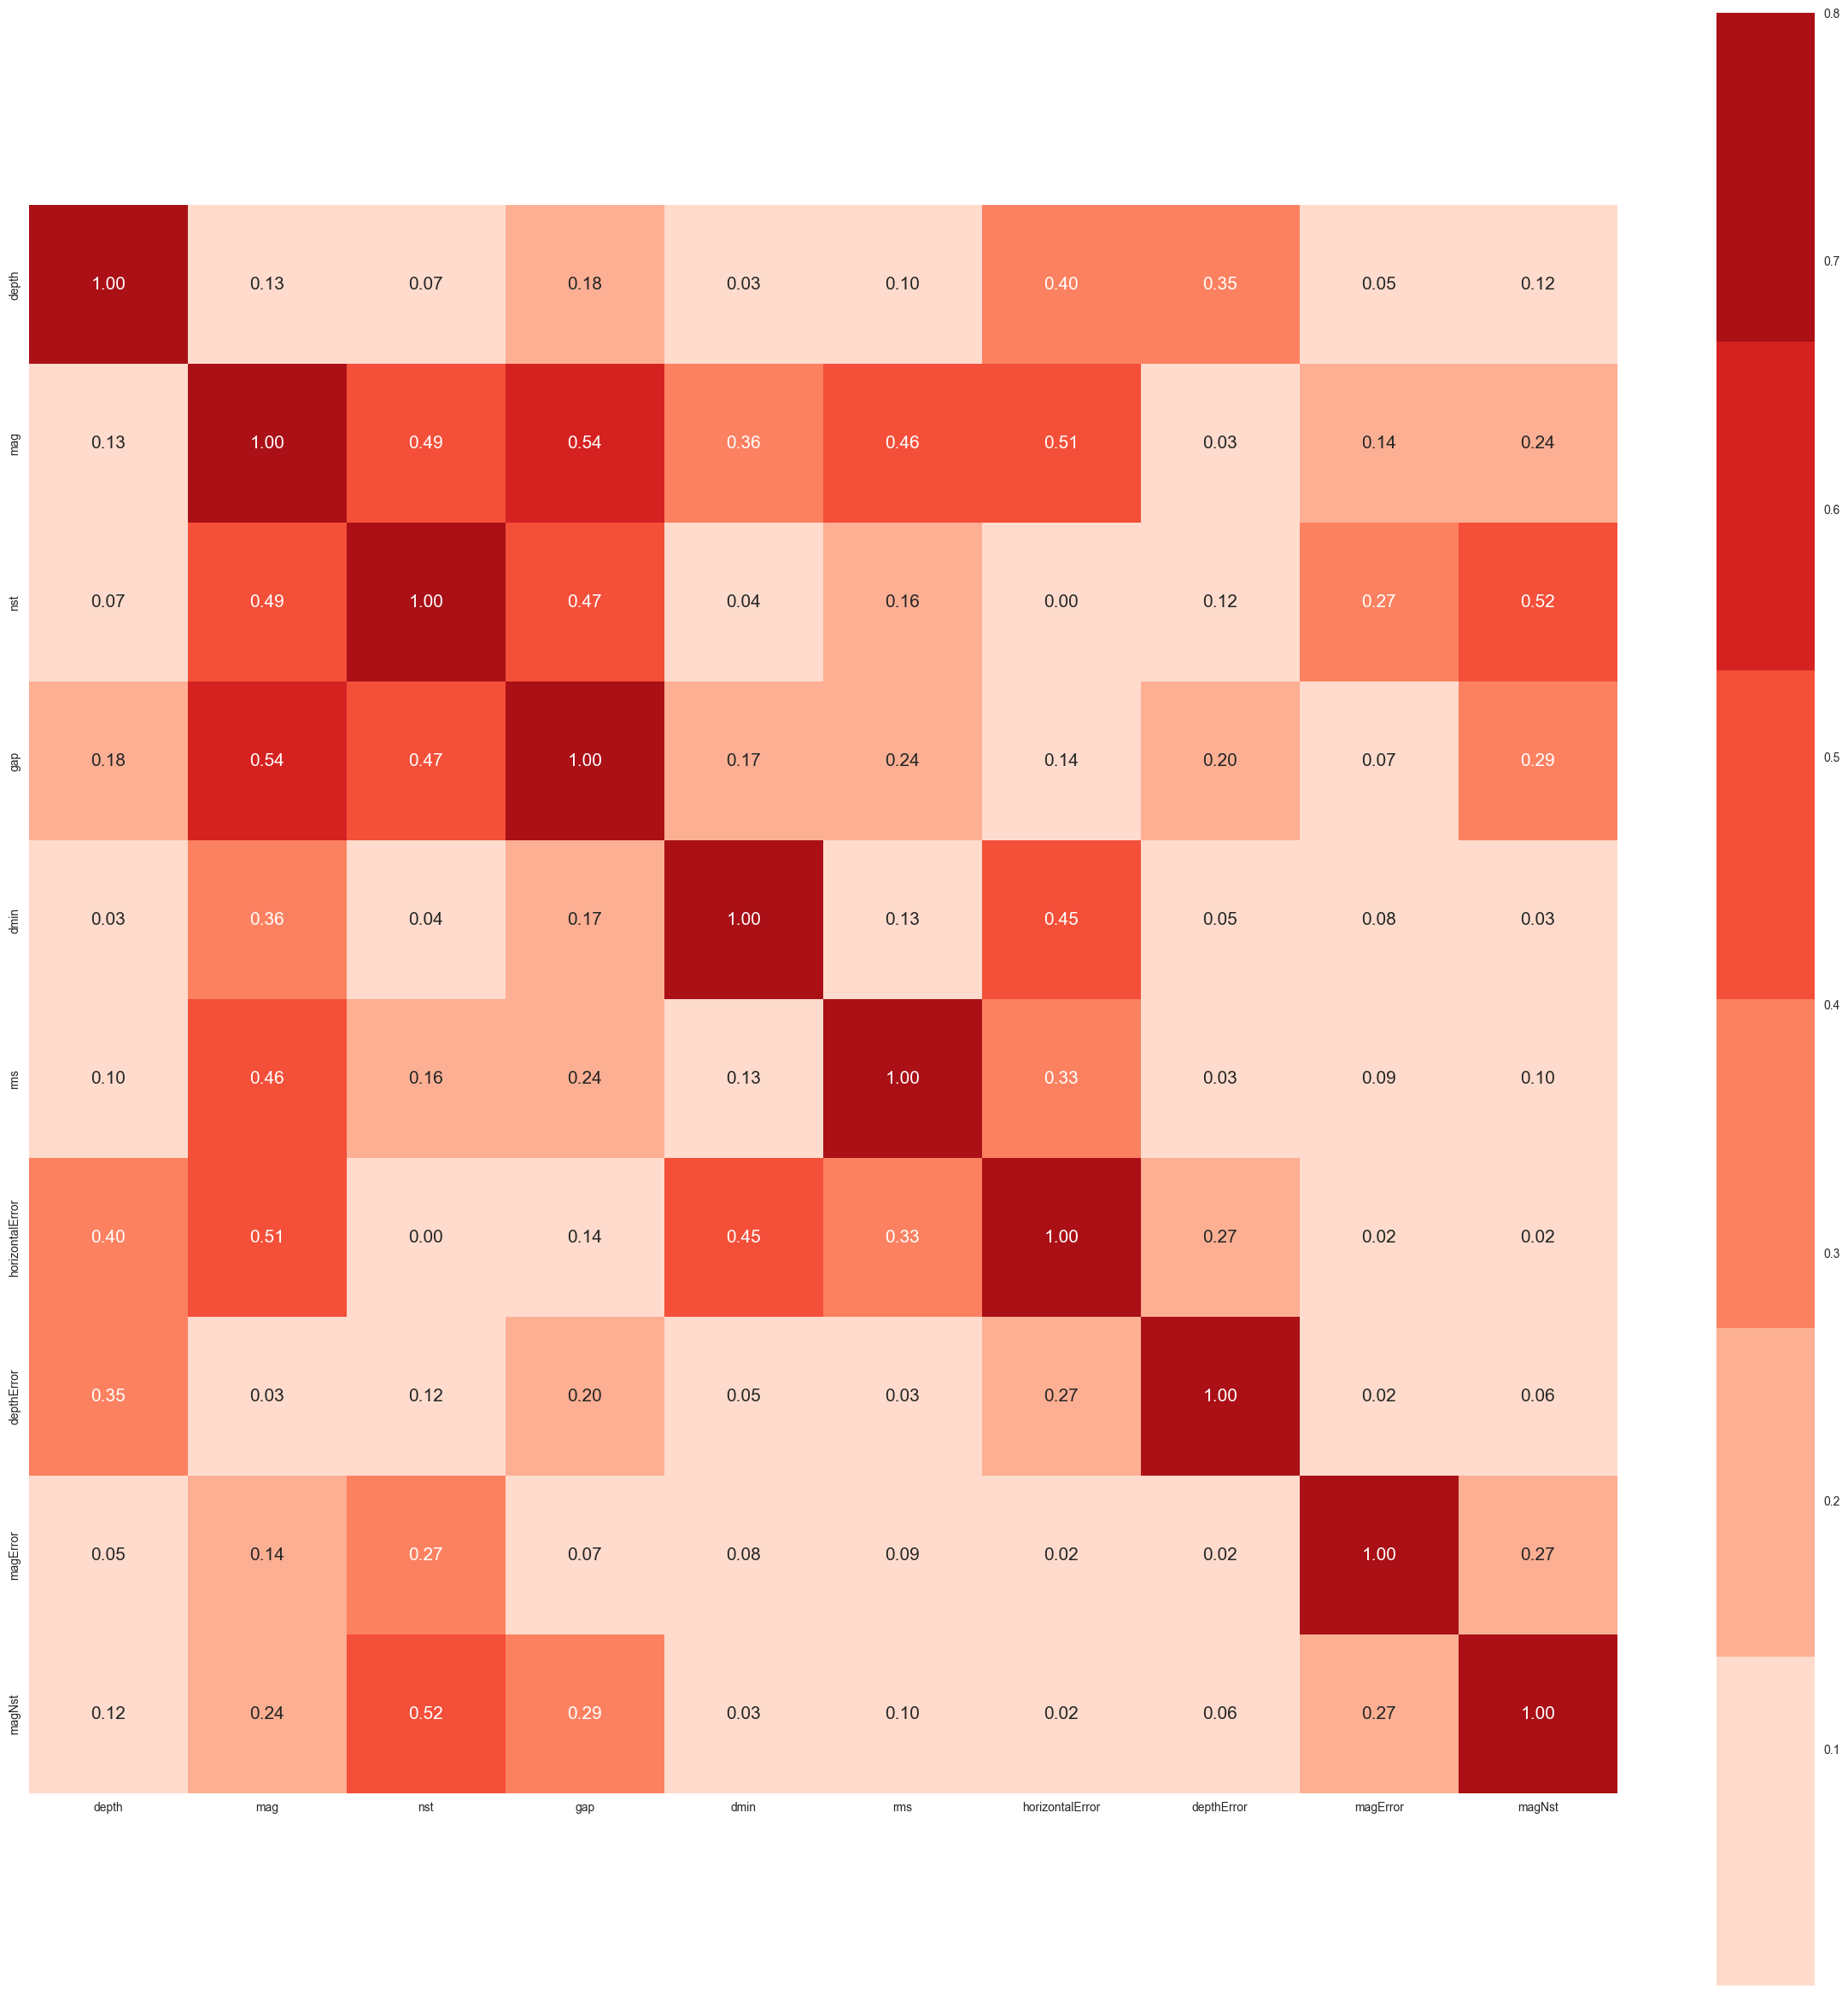

In [22]:
#Generate the correlation matrix
corr_matrix  = X_res.corr().abs()

plt.figure(figsize=(30,30))
sns.heatmap(corr_matrix , vmax=.8, square=True, annot=True, fmt= '.2f', annot_kws={'size': 15}, cmap=sns.color_palette("Reds"))

In [23]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlatiobn greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]
display(to_drop)

['gap', 'horizontalError', 'magNst']

### Clustered dataset

In [24]:
# Filter features with scores greater than 0
selected_features = score[score['score'] > 1]

# Create a list of selected feature names
selected_feature_names = selected_features['Feature'].tolist()

# Create a new DataFrame containing only the selected variables
new_df = X_res[selected_feature_names].copy()

# Display the new DataFrame
new_df.columns

Index(['mag', 'gap', 'rms', 'horizontalError', 'nst', 'dmin', 'depth',
       'magNst'],
      dtype='object')

In [25]:
# Reconstruct the resampled DataFrame with latitude and longitude as the first two columns
resampled_df = pd.DataFrame(X_res, columns=new_df.columns)

# Insert latitude and longitude as the first and second columns
resampled_df.insert(0, 'latitude', df_clustered["latitude"])
resampled_df.insert(1, 'longitude', df_clustered["longitude"])

# Add the resampled target to the DataFrame
resampled_df["label"] = y_res

resampled_df

,latitude,longitude,mag,gap,rms,horizontalError,nst,dmin,depth,magNst,label
0,52.0999,178.5218,0.096154,0.383041,0.093407,0.091361,0.059166,0.263682,0.125824,0.018551,0
1,7.1397,126.7380,0.365385,0.280702,0.252747,0.061756,0.100572,0.267839,0.120600,0.051266,0
2,19.1631,-66.5251,0.255769,0.695906,0.115385,0.015591,0.079869,0.263356,0.039979,0.020808,1
3,-4.7803,102.7675,0.326923,0.523392,0.274725,0.109325,0.066067,0.257594,0.098096,0.008399,0
4,53.3965,-166.9417,0.076923,0.532164,0.164835,0.020609,0.070667,0.256754,0.019529,0.023064,1
...,...,...,...,...,...,...,...,...,...,...,...
28661,NaN,NaN,0.297330,0.268779,0.349114,0.078544,0.064113,0.313911,0.021958,0.013344,0
28662,NaN,NaN,0.365385,0.361230,0.305712,0.095442,0.106091,0.274699,0.133139,0.024124,0
28663,NaN,NaN,0.365385,0.432702,0.384703,0.128526,0.078691,0.340667,0.019529,0.016837,0
28664,NaN,NaN,0.132662,0.427940,0.189604,0.149436,0.094686,0.252585,0.153592,0.027232,0


In [26]:
import pandas as pd

# save clustred df to new df
resampled_df.to_csv('finaldf.csv', index=False)